# 21장. 신경망

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-python-cookbook-2nd/blob/main/ch21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩을 사용하는 경우 다음 명령을 실행하세요.
!pip install lightning ray[data,train,tune,serve] torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/6

In [2]:
import numpy as np
import sklearn
import torch
import matplotlib
import lightning
import ray

print('numpy', np.__version__)
print('sklearn', sklearn.__version__)
print('torch', torch.__version__)
print('matplotlib', matplotlib.__version__)
print('lightning', lightning.__version__)
print('ray', ray.__version__)

numpy 1.26.4
sklearn 1.6.0
torch 2.5.1+cu121
matplotlib 3.8.0
lightning 2.5.0.post0
ray 2.40.0


## 21.1 파이토치 자동미분 사용하기

In [3]:
# 라이브러리를 임포트합니다.
import torch

# 그레이언트가 필요한 토치 텐서를 만듭니다.
t = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# 정방향 계산을 모방한 텐서 연산을 수행합니다.
tensor_sum = t.sum()

# 역전파를 수행합니다.
tensor_sum.backward()

# 그레이디언트를 확인합니다.
t.grad

tensor([1., 1., 1.])

In [4]:
import torch

tensor = torch.tensor([1.0,2.0,3.0], requires_grad=True)
tensor.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## 21.2 신경망을 위해 데이터 전처리하기

In [5]:
# 라이브러리를 임포트합니다.
from sklearn import preprocessing
import numpy as np

# 특성을 만듭니다.
features = np.array([[-100.1, 3240.1],
                     [-200.2, -234.1],
                     [5000.5, 150.1],
                     [6000.6, -125.1],
                     [9000.9, -673.1]])

# 스케일링 객체를 만듭니다.
scaler = preprocessing.StandardScaler()

# 특성을 변환합니다.
features_standardized = scaler.fit_transform(features)

# 특성을 확인합니다.
features_standardized

array([[-1.12541308,  1.96429418],
       [-1.15329466, -0.50068741],
       [ 0.29529406, -0.22809346],
       [ 0.57385917, -0.42335076],
       [ 1.40955451, -0.81216255]])

In [6]:
# 라이브러리를 임포트합니다.
import torch

# 특성을 만듭니다.
torch_features = torch.tensor([[-100.1, 3240.1],
                               [-200.2, -234.1],
                               [5000.5, 150.1],
                               [6000.6, -125.1],
                               [9000.9, -673.1]], requires_grad=True)

# 평균과 표준 편차를 계산합니다.
mean = torch_features.mean(0, keepdim=True)
standard_deviation = torch_features.std(0, unbiased=False, keepdim=True)

# 평균과 표준 편차를 사용해 특성을 표준화합니다.
torch_features_standardized = torch_features - mean
torch_features_standardized /= standard_deviation

# 표준화된 특성을 확인합니다.
torch_features_standardized

tensor([[-1.1254,  1.9643],
        [-1.1533, -0.5007],
        [ 0.2953, -0.2281],
        [ 0.5739, -0.4234],
        [ 1.4096, -0.8122]], grad_fn=<DivBackward0>)

## 21.3 신경망 구성하기

In [7]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn

# 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(10, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수, 옵티마이저를 정의합니다.
loss_criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(network.parameters())

# 신경망을 확인합니다.
network

SimpleNeuralNet(
  (fc1): Linear(in_features=10, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [8]:
# 라이브러리를 임포트합니다.
import torch

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화하고 확인합니다.
SimpleNeuralNet()

SimpleNeuralNet(
  (sequential): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## 21.4 이진 분류기 훈련하기

In [9]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 파이토치 2.0의 옵티마이저를 사용해 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 3
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print("에포크:", epoch+1, "\t손실:", loss.item())

# 신경망을 평가합니다.
with torch.no_grad():
    output = network(x_test)
    test_loss = criterion(output, y_test)
    test_accuracy = (output.round() == y_test).float().mean()
    print("테스트 세트 손실:", test_loss.item(), "\t테스트 세트 정확도:",
        test_accuracy.item())

에포크: 1 	손실: 0.13119998574256897
에포크: 2 	손실: 0.19935432076454163
에포크: 3 	손실: 0.10790599137544632
테스트 세트 손실: 0.08679273724555969 	테스트 세트 정확도: 0.9700000286102295


## 21.5 다중 분류기 훈련하기

In [10]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

N_CLASSES=3
EPOCHS=3

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=N_CLASSES, n_informative=9,
    n_redundant=0, n_features=10, n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.nn.functional.one_hot(torch.from_numpy(target_train).long(),
    num_classes=N_CLASSES).float()
x_test = torch.from_numpy(features_test).float()
y_test = torch.nn.functional.one_hot(torch.from_numpy(target_test).long(),
    num_classes=N_CLASSES).float()

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,3),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.CrossEntropyLoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print("에포크:", epoch+1, "\t손실:", loss.item())

# 신경망을 평가합니다.
with torch.no_grad():
    output = network(x_test)
    test_loss = criterion(output, y_test)
    test_accuracy = (output.round() == y_test).float().mean()
    print("테스트 세트 손실:", test_loss.item(), "\t테스트 세트 정확도:",
        test_accuracy.item())

에포크: 1 	손실: 0.8022041916847229
에포크: 2 	손실: 0.7756164073944092
에포크: 3 	손실: 0.7751263380050659
테스트 세트 손실: 0.8105318546295166 	테스트 세트 정확도: 0.8199999928474426


In [11]:
# 타깃 행렬을 확인합니다.
y_train

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        ...,
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

## 21.6 회귀 모델 훈련하기

In [12]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

EPOCHS=5

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_regression(n_features=10, n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1,1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1,1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,1),
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.MSELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print("에포크:", epoch+1, "\t손실:", loss.item())

# 신경망을 평가합니다.
with torch.no_grad():
    output = network(x_test)
    test_loss = float(criterion(output, y_test))
    print("테스트 세트 MSE:", test_loss)

에포크: 1 	손실: 10764.02734375
에포크: 2 	손실: 1356.510009765625
에포크: 3 	손실: 504.9664001464844
에포크: 4 	손실: 199.1130828857422
에포크: 5 	손실: 191.20835876464844
테스트 세트 MSE: 162.24502563476562


## 21.7 예측하기

In [13]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 3
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print("에포크:", epoch+1, "\t손실:", loss.item())

# 예측을 만듭니다.
with torch.no_grad():
    predicted_class = network.forward(x_train).round()

predicted_class[0]

에포크: 1 	손실: 0.19006992876529694
에포크: 2 	손실: 0.14092369377613068
에포크: 3 	손실: 0.03935524821281433


tensor([1.])

## 21.8 훈련 기록 시각화하기

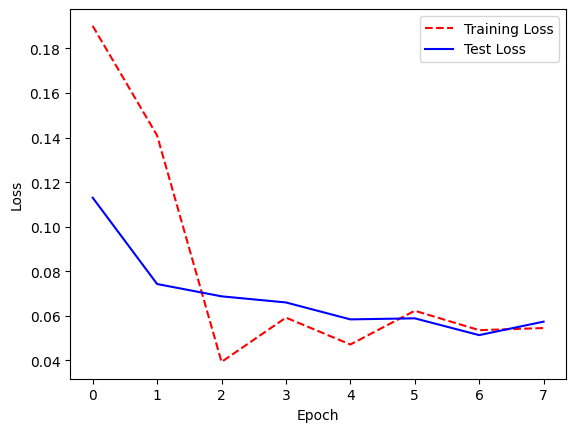

In [14]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 8
train_losses = []
test_losses = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_output = network(x_train)
        train_loss = criterion(output, target)
        train_losses.append(train_loss.item())

        test_output = network(x_test)
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())

# 손실 기록을 시각화합니다.
epochs = range(0, epochs)
plt.plot(epochs, train_losses, "r--")
plt.plot(epochs, test_losses, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

## 21.9 가중치 규제로 과대적합 줄이기

In [15]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4, weight_decay=1e-5)

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 100
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 신경망을 평가합니다.
with torch.no_grad():
    output = network(x_test)
    test_loss = criterion(output, y_test)
    test_accuracy = (output.round() == y_test).float().mean()
    print("테스트 세트 손실:", test_loss.item(), "\t테스트 세트 정확도:",
        test_accuracy.item())

테스트 세트 손실: 0.40308892726898193 	테스트 세트 정확도: 0.9599999785423279


## 21.10 조기종료로 과대적합 줄이기

In [16]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

class LightningNetwork(pl.LightningModule):
    def __init__(self, network):
        super().__init__()
        self.network = network
        self.criterion = nn.BCELoss()
        self.metric = nn.functional.binary_cross_entropy

    def training_step(self, batch, batch_idx):
        # training_step는 훈련 루프를 정의합니다.
        data, target = batch
        output = self.network(data)
        loss = self.criterion(output, target)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 신경망을 초기화합니다.
network = LightningNetwork(SimpleNeuralNet())

# 신경망을 훈련합니다.
trainer = pl.Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min",
    patience=3)], max_epochs=1000)
trainer.fit(model=network, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | network   | SimpleNeuralNet | 465    | train
1 | criterion | BCELoss         | 0      | train
------------------------------------------------------
465       Trainable params
0         Non-trainable params
465       Total params
0.002     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.

Training: |          | 0/? [00:00<?, ?it/s]

In [17]:
# 신경망을 훈련합니다.
trainer = pl.Trainer(max_epochs=1000)
trainer.fit(model=network, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | network   | SimpleNeuralNet | 465    | train
1 | criterion | BCELoss         | 0      | train
------------------------------------------------------
465       Trainable params
0         Non-trainable params
465       Total params
0.002     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


## 21.11 드롭아웃으로 과대적합 줄이기

In [18]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Dropout(0.1), # 10%의 뉴런을 드롭아웃합니다.
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 3
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print("에포크:", epoch+1, "\t손실:", loss.item())

# 신경망을 평가합니다.
with torch.no_grad():
    output = network(x_test)
    test_loss = criterion(output, y_test)
    test_accuracy = (output.round() == y_test).float().mean()
    print("테스트 세트 손실:", test_loss.item(), "\t테스트 세트 정확도:",
        test_accuracy.item())

에포크: 1 	손실: 0.20735645294189453
에포크: 2 	손실: 0.20834866166114807
에포크: 3 	손실: 0.25975286960601807
테스트 세트 손실: 0.1384032666683197 	테스트 세트 정확도: 0.8999999761581421


## 21.12 모델 훈련 진행 과정을 저장하기

In [19]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Dropout(0.1), # 10%의 뉴런을 드롭아웃합니다.
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

# 손실 함수와 옵티마이저를 정의합니다.
criterion = nn.BCELoss()
optimizer = RMSprop(network.parameters())

# 데이터 로더를 정의합니다.
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

# 모델을 컴파일합니다.
network = torch.compile(network)

# 신경망을 훈련합니다.
epochs = 5
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 매 에포크 종료 후 모델을 저장합니다.
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            },
            "model.pt"
        )
    print("에포크:", epoch+1, "\t손실:", loss.item())

에포크: 1 	손실: 0.20735645294189453
에포크: 2 	손실: 0.20834866166114807
에포크: 3 	손실: 0.25975286960601807
에포크: 4 	손실: 0.1492830067873001
에포크: 5 	손실: 0.20664513111114502


## 21.13 신경망 튜닝하기

In [20]:
# 라이브러리를 임포트합니다.
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import RMSprop
from torch.utils.data import random_split, DataLoader, TensorDataset
from ray import tune
from ray import train
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self, layer_size_1=10, layer_size_2=10):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(10, layer_size_1),
            torch.nn.ReLU(),
            torch.nn.Linear(layer_size_1, layer_size_2),
            torch.nn.ReLU(),
            torch.nn.Linear(layer_size_2, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x

config = {
    "layer_size_1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "layer_size_2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=1000,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(
    parameter_columns=["layer_size_1", "layer_size_2", "lr"],
    metric_columns=["loss"]
)

# 신경망을 훈련합니다.
def train_model(config, epochs=3):
    network = SimpleNeuralNet(config["layer_size_1"], config["layer_size_2"])

    criterion = nn.BCELoss()
    optimizer = optim.SGD(network.parameters(), lr=config["lr"], momentum=0.9)

    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

    # 모델을 컴파일합니다.
    network = torch.compile(network)

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train.report(metrics={"loss": loss.item()})

result = tune.run(
    train_model,
    resources_per_trial={"cpu": 2},
    config=config,
    num_samples=1,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial("loss", "min", "last")
print("최상의 구성: {}".format(best_trial.config))
print("최상의 구성에서 최종 검증 손실: {}".format(
    best_trial.last_result["loss"]))

best_trained_model = SimpleNeuralNet(best_trial.config["layer_size_1"],
    best_trial.config["layer_size_2"])

2025-01-08 05:11:39,432	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-01-08 05:11:41,767	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-01-08 05:11:42,359	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2025-01-08_05-11-41   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2025-01-08_05-11-41
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-08_05-11-35_656954_1824/artifacts/2025-01-08_05-11-41/train_model_2025-01-08_05-11-41/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-01-08 05:11:42. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------+
| Trial name    

(train_model pid=5120) No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'



Trial train_model_0c0d9_00000 finished iteration 1 at 2025-01-08 05:12:04. Total running time: 21s
+--------------------------------------------------+
| Trial train_model_0c0d9_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         17.2961 |
| time_total_s                             17.2961 |
| training_iteration                             1 |
| loss                                     0.71165 |
+--------------------------------------------------+

Trial train_model_0c0d9_00000 finished iteration 2 at 2025-01-08 05:12:04. Total running time: 21s
+--------------------------------------------------+
| Trial train_model_0c0d9_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         0.00462 |
| time_total_s                             17.3007 |
| tra

2025-01-08 05:12:04,271	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2025-01-08_05-11-41' in 0.0117s.



Trial status: 1 TERMINATED
Current time: 2025-01-08 05:12:04. Total running time: 21s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------+
| Trial name                status               lr     iter     total time (s)       loss |
+------------------------------------------------------------------------------------------+
| train_model_0c0d9_00000   TERMINATED   0.00443038       27            17.3696   0.682073 |
+------------------------------------------------------------------------------------------+

최상의 구성: {'layer_size_1': 128, 'layer_size_2': 4, 'lr': 0.00443037524521827}
최상의 구성에서 최종 검증 손실: 0.6820727586746216


## 21.14 신경망 시각화하기

In [21]:
# 라이브러리를 임포트합니다.
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from torchviz import make_dot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트를 만듭니다.
features, target = make_classification(n_classes=2, n_features=10,
    n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# 랜덤 시드를 지정합니다.
torch.manual_seed(0)
np.random.seed(0)

# 데이터를 파이토치 텐서로 변환합니다.
x_train = torch.from_numpy(features_train).float()
y_train = torch.from_numpy(target_train).float().view(-1, 1)
x_test = torch.from_numpy(features_test).float()
y_test = torch.from_numpy(target_test).float().view(-1, 1)

# Sequential 클래스를 사용해 신경망을 정의합니다.
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.sequential = torch.nn.Sequential()
        self.sequential.add_module('W0', torch.nn.Linear(10, 16))
        self.sequential.add_module('relu0', torch.nn.ReLU())
        self.sequential.add_module('W1', torch.nn.Linear(16,16))
        self.sequential.add_module('relu1', torch.nn.ReLU())
        self.sequential.add_module('W2', torch.nn.Linear(16, 1))
        self.sequential.add_module('sigmoid', torch.nn.Sigmoid())

    def forward(self, x):
        x = self.sequential(x)
        return x

# 신경망을 초기화합니다.
network = SimpleNeuralNet()

make_dot(network(x_train), params=dict(network.named_parameters())
    ).render("simple_neural_network", format="png")

'simple_neural_network.png'

![](https://raw.githubusercontent.com/rickiepark/ml-with-python-cookbook-2nd/main/simple_neural_network.png)